# Determinación de Volúmenes de estimación

Nuestro **objetivo** es determinar el volumen espacial que sera el limite de estimación para cada una de las Unidades Geológicas. Es decir, la estimación realizada con la información perteneciente a cada unidad geológica definida no rebasara mas allá de los limites representados por este volumen. Para esto, utilizaremos el kriging de indicadores.


## Un poco de teoría acerca del Kriging de indicadores

Para la determinación de cada volumen de estimación, emplearemos la técnica llamada Kriging de Indicadores.

### Formalismo de indicadores

A continuación, usamos métodos indicadores para estimar una variable categórica en el espacio.

Si $i(\bf{u}; z_k)$ es un indicador para una variable categórica $z$ (como es el caso de la variable UG), definida como

$$
i(\bf{u}; z_k) =
\begin{cases} 
    1, & \text{si } Z(\bf{u}) = z_k \\
    0, & \text{si } Z(\bf{u}) \ne z_k 
\end{cases}
$$

![](../../_static/ind1.png "")


entonces la probabilidad de que encontrar esta categoría lejos de las posiciones de nuestra data debería ser igual a la proporción de esta categoría en nuestra base de datos (por la hipótesis de estacionariedad)


por ejemplo, 

* dado la categoria UG = 2, $z_2 = 2$, y dato en $\bf{u}_1$, $z(\bf{u}_1) = 2$, entonces $i(\bf{u}_1; z_2) = 1$
* dado la categoria, $z_1 = 1$, con una proporción en nuestra base de datos de 33.33%, y una variable aleatorea (VA) categorica lejos de los datos, $Z(\bf{u})$, entonces la probabilidad de que la VA tome el valor $z_1$ es igual a $0.333$.

#### Variograma indicador

Los variogramas se calculan y modelan a partir de la transformación indicadora de los datos espaciales y se usan para el kriging de indicadores. El variograma indicador es,

$$
\gamma_i(\mathbf{h}; z_k) = \frac{1}{2N(\mathbf{h})} 
\sum_{\alpha=1}^{N(\mathbf{h})} 
\left[ i(\mathbf{u}_\alpha; z_k) - i(\mathbf{u}_\alpha + \mathbf{h}; z_k) \right]^2
$$

donde $i(\mathbf{u}_\alpha; z_k)$ e $i(\mathbf{u}_\alpha + \mathbf{h}; z_k)$ son las transformaciones indicadoras para la categoría $z_k$ en la posición de cola $\mathbf{u}_\alpha$ y en la posición de cabeza $\mathbf{u}_\alpha + \mathbf{h}$ respectivamente. 

* notar que la transformación indicadora $i(\bf{u},z_k)$ es o bien 0 o bien 1, en cuyo caso $\left[ i(\mathbf{u}_\alpha; z_k) - i(\mathbf{u}_\alpha + \mathbf{h}; z_k) \right]^2$ es igual a 0 cuando los valores en cabeza y cola pertenecen a la misma categoría $ z_k$, o 1 cuando son diferentes.

* la meseta (sill) de un variograma indicador es la varianza indicadora calculada como,

$$
\sigma_i^2 = p \cdot (1 - p)
$$ 

donde $p$ es la proporción de 1's (o de ceros, ya que la función es simétrica respecto a la proporción)


#### Kriging de indicadores

La aplicación de kriging simple a un conjunto indicadores, una por cada categoría para características categóricas, define directamente un modelo de probabilidad local de una cierta categoría en una ubicación desconocida, $\bf{u}$, a partir de nuestros datos.

El estimador de kriging de indicadores se define como,

$$
p^*_{IK}(\mathbf{u}; k) =
\sum_{\alpha=1}^n \lambda_\alpha(k) \cdot i(\mathbf{u}_\alpha; k) 
+ \left( 1 - \sum_{\alpha=1}^n \lambda_\alpha(k) \right) \cdot p(k)
$$

donde $\lambda_\alpha(k)$ es el peso de kriging indicador para el dato $\alpha$ y la categoría $k$, $i(\mathbf{u}_\alpha; k)$ es la transformación indicadora de la categoría $k$ del dato en la ubicación $\mathbf{u}_\alpha$ y $p(k)$ la probabilidad categórica.

Los pasos para el kriging de indicadores son,

1. Establecer una serie de categorías. En nuestro caso, estas ya fueron definidas en los capítulos anteriores.

2. Aplicar la transformación indicadora a los datos.

3. Calcular el *variograma indicador* a partir de la transformación indicadora de los datos para cada categoría.

4. Aplicar kriging de indicadores para estimar la probabilidad acumulada para características continuas o la probabilidad para características categóricas en una ubicación no muestreada, usando el variograma indicador para cada categoría.

Comentario general,

* se necesita un modelo de variograma para cada categoría; por lo tanto, es un problema de inferencia difícil.


## Cargar las bibliotecas requeridas

El siguiente código carga las bibliotecas requeridas.

In [ ]:
#### Instalar libreria de geoestadistica Geostatspy
!pip install geostatspy

In [256]:
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data

import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))  

import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?

import matplotlib.pyplot as plt                               # for plotting
import matplotlib as mpl                                      # custom colorbar
import matplotlib.ticker as mticker                           # custom colorpar ticks
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

import os
import matplotlib.image as mpimg
import subprocess
import time
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec

import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py

# trimmed inverted rainbow colormap hsv removing magenta tones
cmap = mpl.colors.ListedColormap(mpl.cm.hsv(np.linspace(0.0, 0.70, 256))).reversed()


GeostatsPy version: 0.0.78


Nuestro punto de partida sera la base de datos simplificada de la sección anterior.

In [257]:
## Cargar data simplificada de la sección anterior

import pandas as pd
import numpy as np

# Cargar base de datos en pandas y aproximar a dos decimales
df = pd.read_csv('data.csv', sep=',', encoding='latin1').round(2)
df['UG'] = df['UG'].astype(int)  # Asegurarse de que la columna 'UG' sea de tipo entero

# Guardar data con indicadores en formato GSLIB
GSLIB.Dataframe2GSLIB('./01_data/data.dat',df)  # guardar data

df.head()  # mostrar las primeras filas de la data

X           Y        Z  cu_pct  UG
0  472187.34  6925805.69  4211.77    0.02   2
1  472187.74  6925806.53  4205.84    0.01   2
2  472188.09  6925807.38  4199.92    0.01   2
3  472188.47  6925808.28  4194.00    0.01   2
4  472188.88  6925809.22  4188.08    0.01   2

## Proporciones de cada UG en nuestra base de datos

Verificamos la proporción de cada UG en nuestra base de datos. (Para este ejemplo solo consideramos las UGs 2, 3 y 4.)

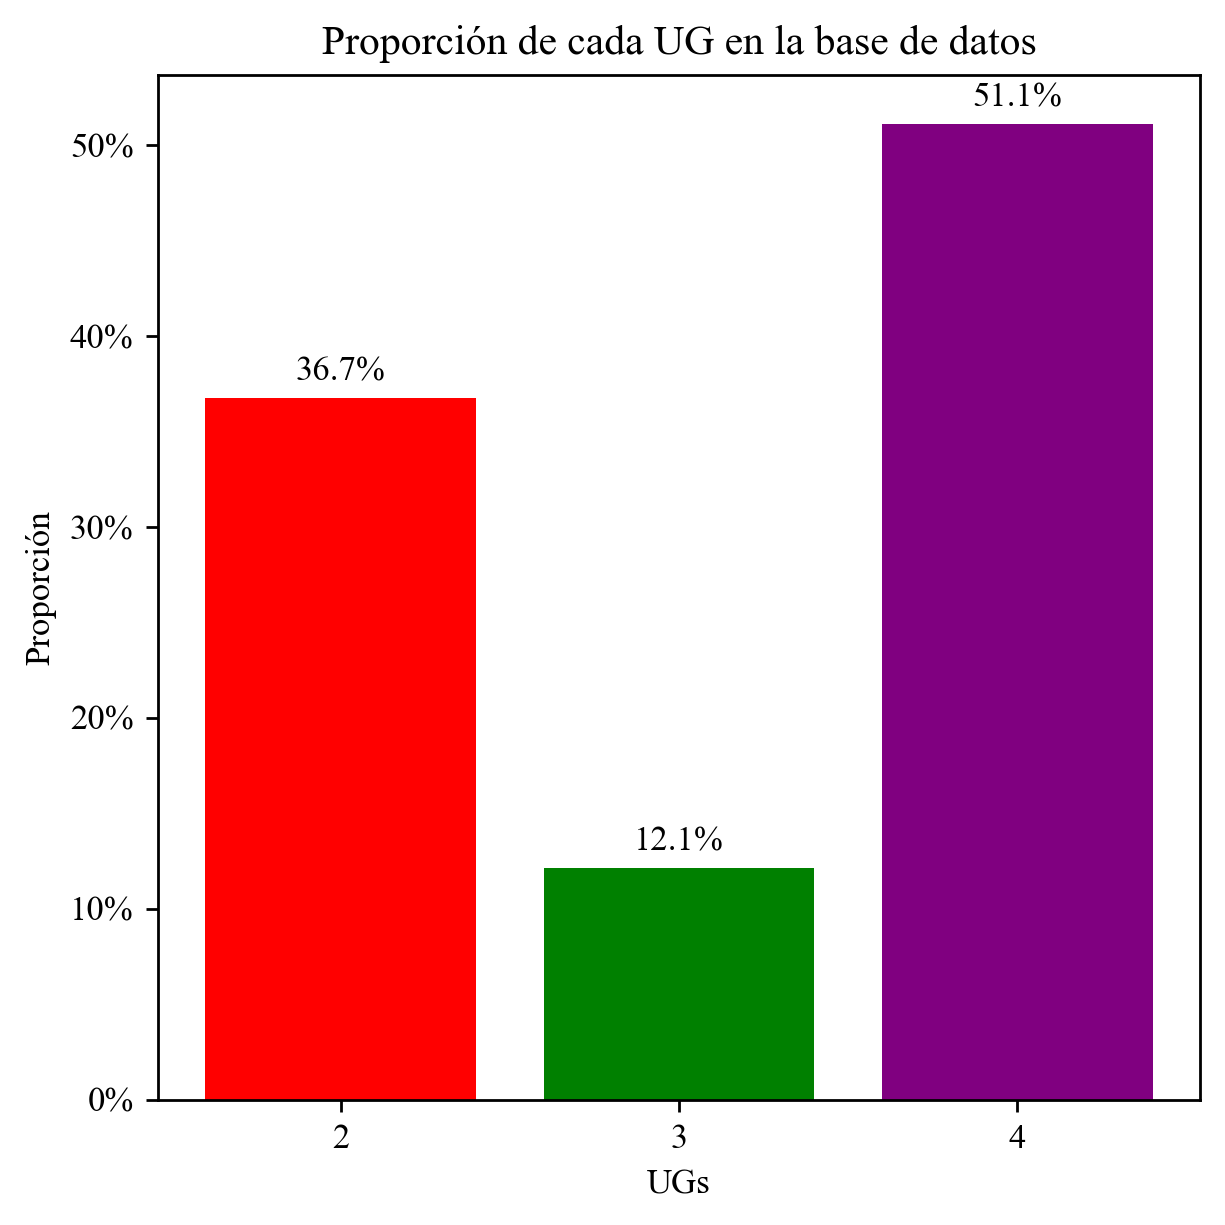

In [258]:
fig, ax = plt.subplots(figsize=(5,5))
ax.clear()

plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
plt.rcParams["font.family"] = "Times New Roman"

# Proporciones de cada UG en nuestra base de datos
color = ['red','green','purple']

proportions = df['UG'].value_counts(normalize=True).sort_index()
labels = proportions.index.astype(int).astype(str)

bars = ax.bar(labels, proportions.values, color=color[:len(proportions)])
ax.set_title('Proporción de cada UG en la base de datos')
ax.set_xlabel('UGs')
ax.set_ylabel('Proporción')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

for bar, p in zip(bars, proportions.values):
    ax.annotate(f"{p*100:.1f}%", xy=(bar.get_x() + bar.get_width() / 2, p),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

fig.tight_layout()
plt.show()

## Codificar base de datos en funcion de indicadores

Convendrá agregar a nuestra base de datos 3 columnas nuevas que codifiquen la variable indicador para cada UG

In [ ]:
# Agregar columnas de indicadores para cada UG

df['indicador UG_2'] = np.where(df['UG'] == 2, 1, 0)
df['indicador UG_3'] = np.where(df['UG'] == 3, 1, 0)
df['indicador UG_4'] = np.where(df['UG'] == 4, 1, 0)

# Guardar data con indicadores en formato GSLIB
GSLIB.Dataframe2GSLIB('./01_data/data_indicadores.dat',df)  # guardar data con indicadores en formato GSLIB

df.head()  # mostrar las primeras filas de la data

Podemos, en base a esta información, calcular la media de los indicadores (igual a la proporción) y la varianza.

In [260]:
#   calcular la media de los indicadores (igual a la proporcion) y la varianza.
mean_UG2 = df['indicador UG_2'].mean()
var_UG2 = df['indicador UG_2'].var()
mean_UG3 = df['indicador UG_3'].mean()
var_UG3 = df['indicador UG_3'].var()
mean_UG4 = df['indicador UG_4'].mean()
var_UG4 = df['indicador UG_4'].var()

print(f"UG2 - Media: {mean_UG2:.2f}, Varianza: {var_UG2:.2f}")
print(f"UG3 - Media: {mean_UG3:.2f}, Varianza: {var_UG3:.2f}")
print(f"UG4 - Media: {mean_UG4:.2f}, Varianza: {var_UG4:.2f}")

UG2 - Media: 0.37, Varianza: 0.23
UG3 - Media: 0.12, Varianza: 0.11
UG4 - Media: 0.51, Varianza: 0.25


## Variograma experimental de indicadores

In [261]:
## Crear directorio de trabajo para GSLIB
os.makedirs("01_data", exist_ok=True)
os.makedirs("02_parametros", exist_ok=True)
os.makedirs("03_resultados", exist_ok=True)

#### Cálculo experimental del variograma

Definimos la siguiente función, que nos permitirá optimizar la ejecución del calculo de variogramas.

In [262]:
def gamv_3d(df, xcol, ycol, zcol, vcol, nlag, tmin,tmax, lagdist,lag_tol, azi, atol, bandh, dip, dtol, bandv, isill):
    """Calcula el variograma experimental 3D usando GSLIB GAMV."""
    lag = []
    gamma = []
    npair = []

    df_ext = pd.DataFrame({"X": df[xcol], "Y": df[ycol], "Z": df[zcol],"Variable": df[vcol]})
    GSLIB.Dataframe2GSLIB("01_data/gamv_out.dat", df_ext)

    with open("02_parametros/gamv.par", "w") as f:
        f.write("                  Parameters for GAMV                                      \n")
        f.write("                  *******************                                      \n")
        f.write("                                                                           \n")
        f.write("START OF PARAMETERS:                                                       \n")
        f.write("01_data/gamv_out.dat                    -file with data                            \n")
        f.write("1   2   3                         -   columns for X, Y, Z coordinates      \n")
        f.write("1   4   0                         -   number of variables,col numbers      \n")
        f.write( str(tmin) + " " + str(tmax)+ "  -   trimming limits                      \n")
        f.write("03_resultados/gamv.out                          -file for variogram output               \n")
        f.write(str(nlag) + "                      -number of lags                          \n")
        f.write(str(lagdist) + "                       -lag separation distance                 \n")
        f.write(str(lag_tol) + "                   -lag tolerance                           \n")
        f.write("1                                 -number of directions                    \n")
        f.write(str(azi) + " " + str(atol) + " " + str(bandh) + " " +str(dip) + " " + str(dtol) + " " + str(bandv)+ "  -azm,atol,bandh,dip,dtol,bandv \n")
        f.write(str(isill) + "                    -standardize sills? (0=no, 1=yes)        \n")
        f.write("1                                 -number of variograms                    \n")
        f.write("1   1   1                         -tail var., head var., variogram type    \n")

    # Ejecutar gamv de GSLIB
    result = subprocess.run(["./Gslib90/gamv", "./02_parametros/gamv.par"], capture_output=True, text=True, check=True)

    with open("03_resultados/gamv.out") as f:
        next(f)  # skip the first line

        for line in f:
            _, l, g, n, *_ = line.split()
            lag.append(float(l))
            gamma.append(float(g))
            npair.append(float(n))

    return lag, gamma, npair, result

def vmodel(nlag,xlag,mazm,mdip,vario):
    """Calcula el variograma experimental 3D usando GSLIB VMODEL."""
    lag = []
    gamma = []

    with open("02_parametros/vmodel.par", "w") as f:
        f.write("                  Parameters for VMODEL                                      \n")
        f.write("                  *******************                                      \n")
        f.write("                                                                           \n")
        f.write("START OF PARAMETERS:                                                     \n")
        f.write("./03_resultados/vmodel.out                   -file for variogram output                 \n")
        f.write("1 " + str(nlag)+ "                          -number of directions and lags             \n")
        f.write(str(mazm) + " " + str(mdip) + " " + str(xlag) + "  -azm, dip, lag distance                     \n")
        f.write(str(vario["nst"]) + " " + str(vario['nug']) + "  -nst, nugget effect                        \n")
        f.write(str(vario["it"][0]) + " " + str(vario["cc"][0]) + " " + str(vario["azi"][0]) + " " + str(vario["dip"][0])  + "  0.0    -it,cc,ang1,ang2,ang3                       \n")
        f.write("         " + str(vario["hmaj"][0]) + " " + str(vario["hmin"][0]) + " " + str(vario["hvert"][0])  + "  -a_hmax, a_hmin, a_vert                    \n")
        f.write(str(vario["it"][1]) + " " + str(vario["cc"][1]) + " " + str(vario["azi"][1]) + " " + str(vario["dip"][1]) + "  0.0    -it,cc,ang1,ang2,ang3                       \n")
        f.write("         " + str(vario["hmaj"][1]) + " " + str(vario["hmin"][1]) + " " + str(vario["hvert"][1])  + "  -a_hmax, a_hmin, a_vert                    \n")

    # Ejecutar vmodel de GSLIB
    result = subprocess.run(["./Gslib90/vmodel", "./02_parametros/vmodel.par"], capture_output=True, text=True, check=True)

    with open("03_resultados/vmodel.out") as f:
        next(f)  # skip the first line

        for line in f:
            _, l, g, _, _, *_ = line.split()
            lag.append(float(l))
            gamma.append(float(g))

    return lag, gamma, result

Estamos listos para calcular los variogramas. Vamos a calcular variogramas isótropos para todas las UGs. Algunas notas sobre los parámetros que elegí:

In [ ]:
tmin = -9999.; tmax = 9999.; 
lag_dist = 50.0; lag_tol = 25.0; nlag = 15; bandh = 9999.9; azi = 0; atol = 90.0; isill = 0; 
dip = 0; dtol = 90; bandv = 9999.9; 

* **number of variables,col numbers** indica el numero de variables a considerar (1, solo cu en nuestro caso) y en que columna se encuentra esta variable en el archivo
* **trimming limits** son límites de recorte — establecidos para no tener impacto, no es necesario filtrar los datos.
* **lag separation distance**, **lag tolerance** son la distancia de lag y la tolerancia de lag — definidos según el espaciado común de los datos (50 m) y con una tolerancia del 50% de la distancia de lag para un mayor suavizado.
* **number of lags** es el número de lags — definido para extenderse un poco más allá del 50% del rango de los datos.
* **bandh** es el ancho de banda horizontal — configurado para no tener efecto.
* **bandv** es el ancho de banda vertical — configurado para no tener efecto.
* **azi** es el acimut — no tiene efecto porque hemos fijado atol (tolerancia de acimut) en 90.0.
* **standardize sills?** es un indicador para estandarizar la distribución a varianza 1 — no será usado durante este curso.
* **number of variograms** indica el numero de variogramas que calcularemos. 3 en nuestro caso (uno para cada indicador).
* **tail var., head var., variogram type** finalmente indicamos que variables entran en el cálculo del variograma y el tipo (variograma tradicional si el indicador es 1)


Otros tipos de variogramas se puede obtener setiando 

type 1 = traditional semivariogram
     ; 2 = traditional cross semivariogram
     ; 3 = covariance
     ; 4 = correlogram
     ; 5 = general relative semivariogram
     ; 6 = pairwise relative semivariogram
     ; 7 = semivariogram of logarithms
     ; 8 = semimadogram
     ; 9 = indicator semivariogram - continuous
     ; 10= indicator semivariogram - categorical


Probemos estos parámetros y visualicemos los resultados.

In [264]:
lag_UG2, UG2_gamma, UG2_npair, result = gamv_3d(df,"X","Y","Z","indicador UG_2", nlag, tmin,tmax, lag_dist,lag_tol, azi, atol, bandh, dip, dtol, bandv, isill)
lag_UG3, UG3_gamma, UG3_npair, result = gamv_3d(df,"X","Y","Z","indicador UG_3", nlag, tmin,tmax, lag_dist,lag_tol, azi, atol, bandh, dip, dtol, bandv, isill)
lag_UG4, UG4_gamma, UG4_npair, result = gamv_3d(df,"X","Y","Z","indicador UG_4", nlag, tmin,tmax, lag_dist,lag_tol, azi, atol, bandh, dip, dtol, bandv, isill)


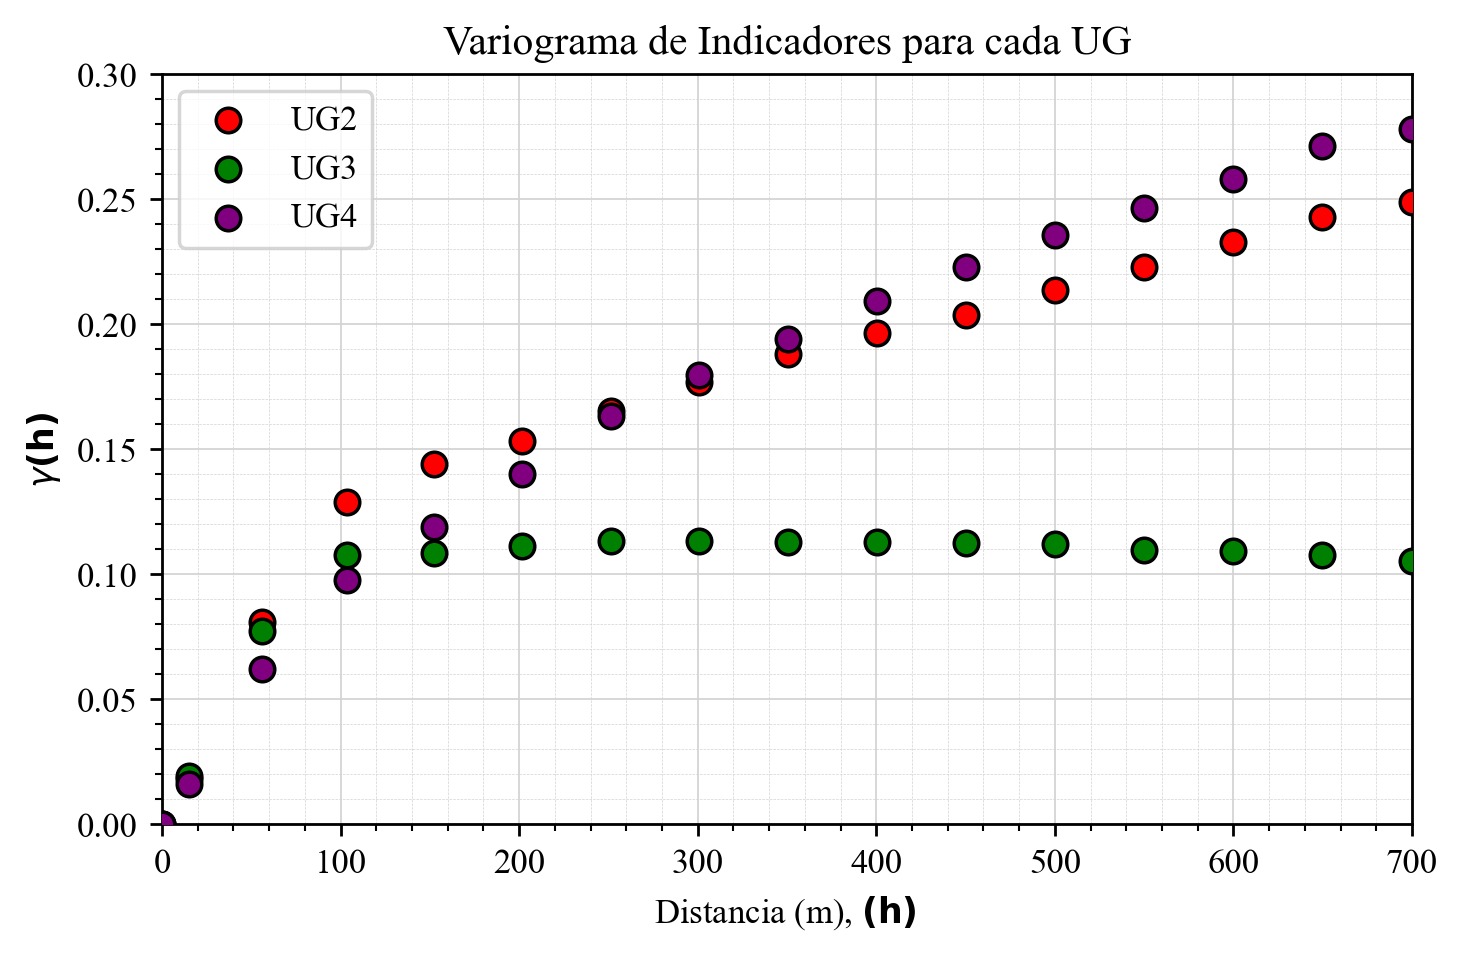

In [265]:
fig, ax = plt.subplots(figsize=(5,2.5))
ax.clear()

plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(lag_UG2,UG2_gamma,color = 'red',edgecolor='black',s=50,marker='o',label = 'UG2',zorder=8)
plt.scatter(lag_UG3,UG3_gamma,color = 'green',edgecolor='black',s=50,marker='o',label = 'UG3',zorder=8)
plt.scatter(lag_UG4,UG4_gamma,color = 'purple',edgecolor='black',s=50,marker='o',label = 'UG4',zorder=8)

plt.xlabel(r'Distancia (m), $\bf(h)$ '); plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma de Indicadores para cada UG')
plt.xlim([0,700]); plt.ylim([0,.3]); plt.legend(loc='upper left');

## add grid lines
plt.grid(visible=True, which='major', color='lightgrey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='--', linewidth=0.2)
plt.minorticks_on()


plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

Nota: se pueden graficar los puntos cambiando su tamaño de acuerdo al número relativo de pares, aunque esto no es visible en nuestro caso, por ejemplo, ```s=por_maj_npair``` o escalando por un factor ```s=por_maj_npair/17```.

- Los puntos pequeños tienen menos pares de datos; por lo tanto, son menos confiables.

Construyamos un modelo razonable hasta la meseta (sill).

## Modelado del variograma


Usamos la función make_variogram de GeostatsPy para construir un objeto modelo de variograma.

- Es un diccionario para almacenar de forma compacta los parámetros del modelo de variograma que se usan en la visualización, kriging y simulación.

Los parámetros del modelo de variograma incluyen:

- **nug** - aporte del efecto pepita (nugget) a la meseta (sill)
- **nst** - número de estructuras anidadas (1 o 2)
- **it** - tipo para la estructura (1 - esférico, 2 - exponencial, 3 - gaussiano)
- **cc** - contribución de cada estructura anidada (las contribuciones + nugget deben sumar la meseta)
- **azi** - acimut para esta estructura (dirección mayor), la minor es ortogonal
- **hmaj** - alcance en la dirección mayor
- **hmin** - alcance en la dirección menor

Usamos arreglos para it, cc, azi, hmaj y hmin cuando hay más de una estructura anidada.

- Si solo usamos 1 estructura (más opción de nugget), omita los parámetros de la segunda estructura y estos por defecto serán $cc2 = 0$ (sin contribución).

Tomemos como ejemplo la UG 2. Aquí está mi modelo:

In [266]:
nug = 0.0; nst = 2     # definimos el efecto pepa (0.0) y el número de estructuras anidadas (1)
it1 = 1; cc1 = 0.1; azi1 = 0; dip1=0; hmaj1 = 120; hmin1 = hmaj1; hvert1 = hmaj1;  # 1 estructura anidada (exponencial)
it2 = 1; cc2 = (var_UG2 - cc1); azi2 = 0; dip2=0; hmaj2 = 700; hmin2 = hmaj2; hvert2 = hmaj2;  # 1 estructura anidada (exponencial)

vario_UG2 = geostats.make_variogram3D(nug,nst,it1,cc1,azi1,dip1,hmaj1,hmin1,hvert1,it2,cc2,azi2,dip2,hmaj2,hmin2,hvert2)  # crear el objeto del modelo de variograma

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


#### Trazado del modelo de variograma

Para trazar el variograma usamos el programa `vmodel` que proyecta el modelo a un conjunto de distancias de lag en las direcciones mayor y menor.

Las entradas para `vmodel` son:

- **nlag** - número de puntos a lo largo del variograma para la proyección
- **xlag** - tamaño del lag para la proyección
- **azm** - dirección de la proyección en azimut (trabajamos en 2D)
- **vario** - el diccionario del modelo de variograma creado con `make_variogram`

Nota: esta función es solo para visualización; por eso es habitual usar un **xlag** muy pequeño y un **nlag** grande para una visualización de alta resolución del modelo.

Las salidas de `vmodel` incluyen:

- **lag distance** - distancia offset a lo largo de la proyección (el $\mathbf{h}$ en el gráfico)
- **variogram** - valor del variograma en esa distancia de lag (el $\gamma(\mathbf{h})$)
- **resutls** - verificación de la correcta ejecución (imprimir en caso de que algo ande mal)

Tenemos 2 estructuras y sin efecto pepa como ejemplo para el caso de la UG 2.  

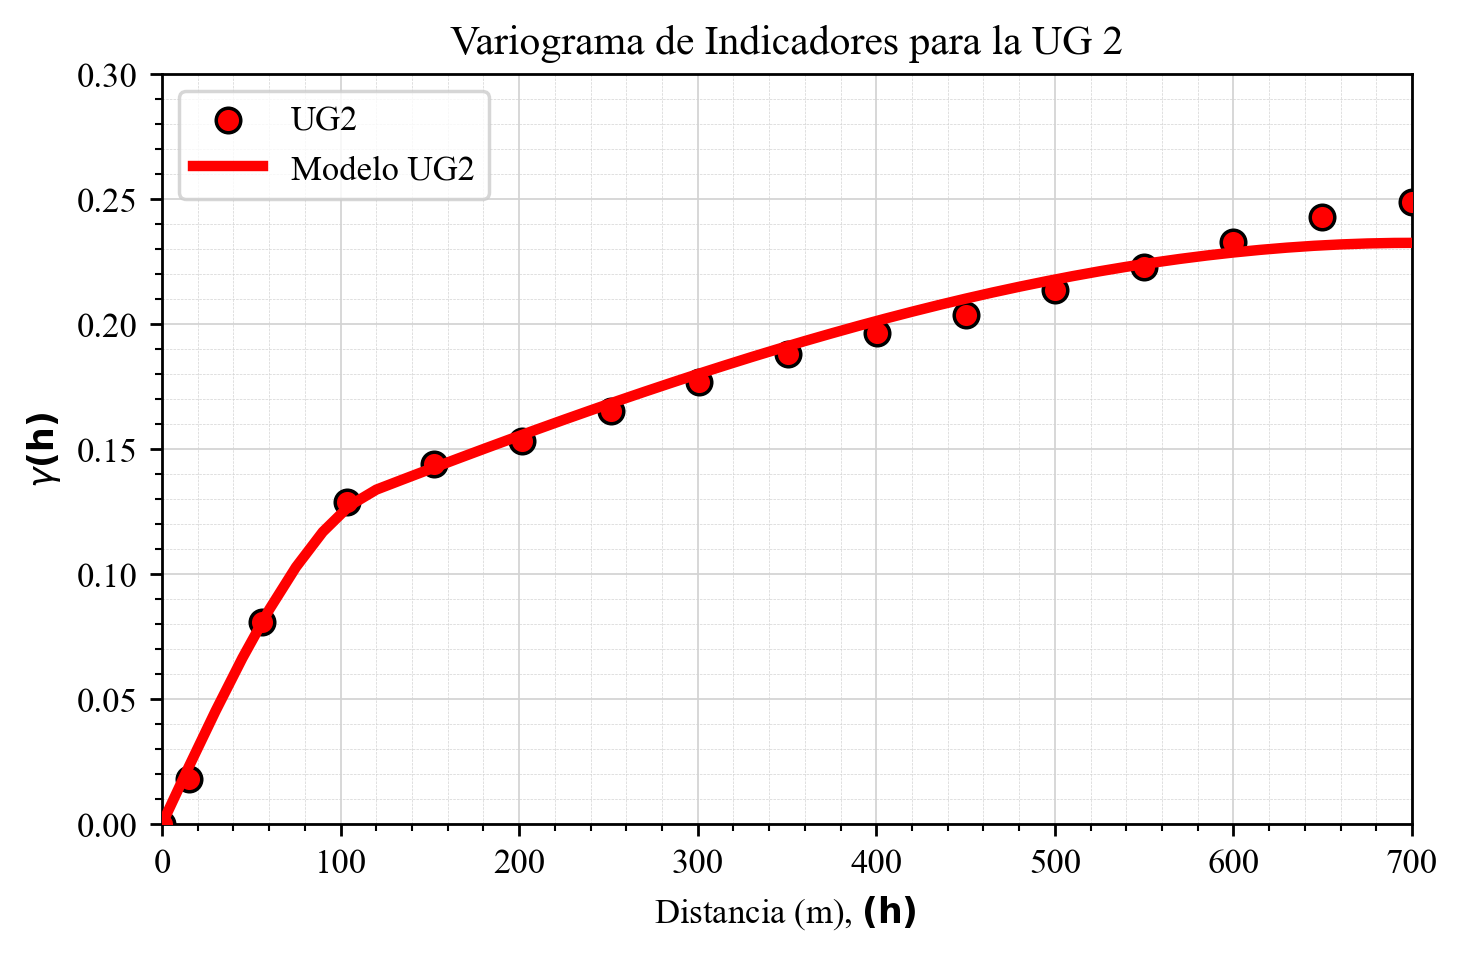

In [267]:
nlag = 50; xlag = 15; azm = 0; dip = 0;  # project the model in 0 azimuth
h_UG2 , gam_UG2 , result = vmodel(nlag,xlag,azm,dip,vario_UG2)

fig, ax = plt.subplots(figsize=(5,2.5))
ax.clear()

plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(lag_UG2,UG2_gamma,color = 'red',edgecolor='black',s=50,marker='o',label = 'UG2',zorder=10)

plt.plot(h_UG2,gam_UG2,color='red',lw=3,zorder=100,label = 'Modelo UG2')

plt.xlabel(r'Distancia (m), $\bf(h)$ '); plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma de Indicadores para la UG 2')
plt.xlim([0,700]); plt.ylim([0,.3]); plt.legend(loc='upper left');

## add grid lines
plt.grid(visible=True, which='major', color='lightgrey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='--', linewidth=0.2)
plt.minorticks_on()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

Se ve bastante bien; recuerde que solo modelamos hasta la meseta (sill) y no por encima de ella.

Ahora modelamos los variogramas para el resto de las categorías.

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 


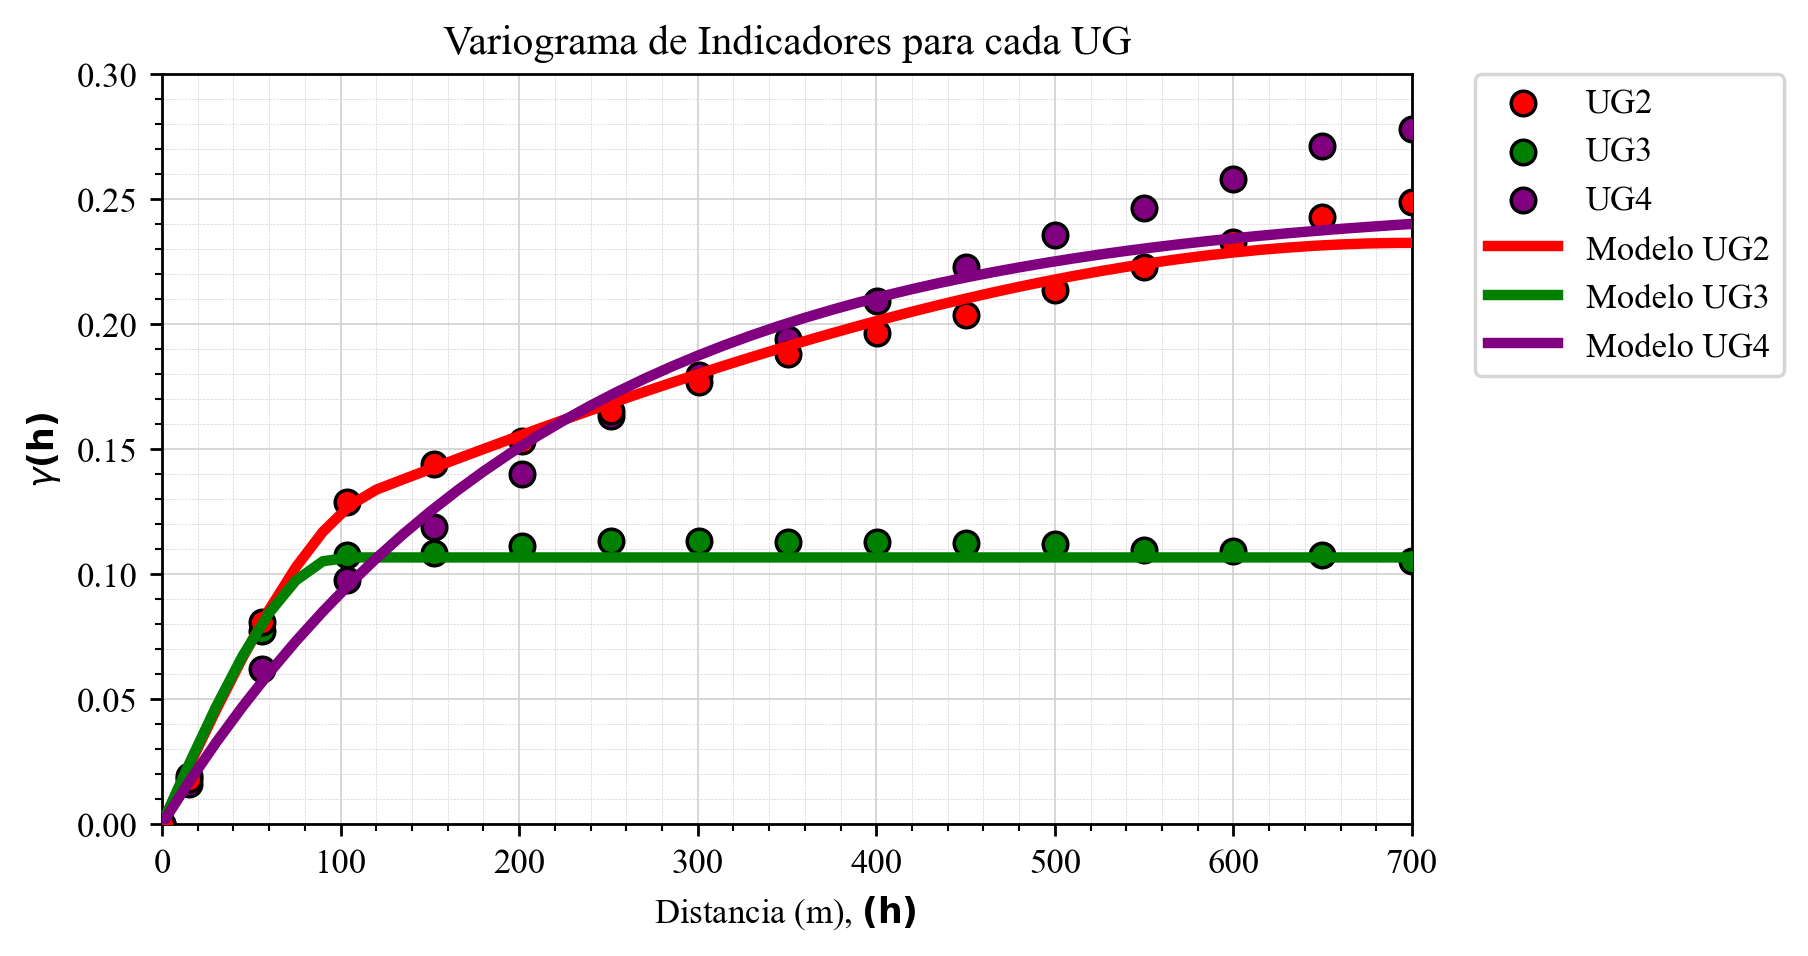

In [268]:
nug = 0.0; nst = 1                                             # Variograma para UG 3 (verde)
it1 = 1; cc1 = (var_UG3 - nug); azi1 = 0; dip = 0; hmaj1 = 100; hmin1 = hmaj1; hvert1 = hmaj1;

vario_UG3 = geostats.make_variogram3D(nug,nst,it1,cc1,azi1,dip1,hmaj1,hmin1,hvert1) # crear objeto variograma modelado

h_UG3,gam_UG3,result = vmodel(nlag,xlag,azm,dip1,vario_UG3)

nug = 0.0; nst = 1                                             # Variograma para UG 4 (morado)
it1 = 2; cc1 = (var_UG4 - nug); azi1 = 0; dip = 0; hmaj1 = 650; hmin1 = hmaj1; hvert1 = hmaj1;

vario_UG4 = geostats.make_variogram3D(nug,nst,it1,cc1,azi1,dip1,hmaj1,hmin1,hvert1) # crear objeto variograma modelado

h_UG4,gam_UG4,result = vmodel(nlag,xlag,azm,dip1,vario_UG4)

fig, ax = plt.subplots(figsize=(5,2.5))     # Plotear todos los variogramas juntos
ax.clear()

plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(lag_UG2,UG2_gamma,color = 'red',edgecolor='black',s=50,marker='o',label = 'UG2',zorder=10)
plt.scatter(lag_UG3,UG3_gamma,color = 'green',edgecolor='black',s=50,marker='o',label = 'UG3',zorder=9)
plt.scatter(lag_UG4,UG4_gamma,color = 'purple',edgecolor='black',s=50,marker='o',label = 'UG4',zorder=8)

plt.plot(h_UG2,gam_UG2,color='red',lw=3,zorder=100,label = 'Modelo UG2')
plt.plot(h_UG3,gam_UG3,color='green',lw=3,zorder=100,label = 'Modelo UG3')
plt.plot(h_UG4,gam_UG4,color='purple',lw=3,zorder=100,label = 'Modelo UG4')

plt.xlabel(r'Distancia (m), $\bf(h)$ '); plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma de Indicadores para cada UG')
plt.xlim([0,700]); plt.ylim([0,.3]); plt.legend(loc='upper left');

## add grid lines
plt.grid(visible=True, which='major', color='lightgrey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='--', linewidth=0.2)
plt.minorticks_on()

# mover legenda fuera del plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

### Parámetros de la malla 3D de estimación

Antes de continuar con la estimación, definamos los parámetros de la malla 3D donde se realizará la estimación de las UGs, calculadas ya en la sección anterior.

In [270]:
xmin = 471116.24; xmax = 473023.89			# rango de valores x
ymin = 6924721.57; ymax = 6926164.63			# rango de valores y
zmin = 2950.02; zmax = 4445.78				# rango de valores z

xsiz = 15; ysiz = 15; zsiz = 15				# tamaño de celda
nx = 128; ny = 97; nz = 100				# número de celdas

tmin = -999; tmax = 999;                                      # límites de recorte de datos

icx = int(nx/2); cx = xmn + icx*xsiz # center layers and slices for plotting
icy = int(ny/2); cy = ymn + icy*ysiz
icz = int(nz/2); cz = zmn + icz*zsiz


## Kriging de Indicadores

Aplicamos los conceptos desarrollados anteriormente y los modelos de variograma obtenidos para cada indicador.

Recordar que las medias de los indicadores representan la proporción global en el dominio y, por lo tanto, sera nuestro valor por defecto lejos de las muestras.

Este capítulo presenta los programas de kriging de GSLIB. Estos programas permiten kriging simple (SK), kriging ordinario (OK) y kriging con varios modelos de tendencia (KT).

El programa ```kt3d``` ofrece un programa de kriging 3D bastante avanzado para puntos o bloques mediante kriging simple (SK), kriging ordinario (OK) o kriging con un modelo de tendencia polinómica (no sera revisado en este curso).

Los parámetros requeridos por el programa principal ```kt3d``` se listan a continuación:

- **datafl**: archivo de entrada con los datos en formato GSLIB.
- **DH, X, Y, Z, icolvr, icolsec**: columnas para la columna que contiene los codigos DH (ya los borramos y no seran necesarios - valor 0) coordenadas x, y, z, la variable a estimar y la variable de deriva externa (o media no estacionaria - no utilizada en este curso).
- **tmin y tmax**: triming limits o valores fuera de este rango (menores estrictamente que tmin o mayores o iguales que tmax) se ignoran.**: valores fuera de este rango (menores estrictamente que tmin o mayores o iguales que tmax) se ignoran.**.
- **option**: 0 para kriging sobre una rejilla de puntos o bloques, 1 para valida validación cruzada con los datos en datafl, 2 para jackknife con los datos del archivo siguiente.
- **jackfl**: archivo con las ubicaciones para realizar estimaciones (opción jackknife).
- **icoljx, icoljy, icoljz, icoljvr, icoljsec**: columnas para x, y, z, la variable y la variable secundaria en jackfl.kfl.
- **idbg**: nivel entero de depuración entre 0 y 3. A mayor nivel, más información entregada. Los niveles usuales son 0 y 1; 2 y 3 imprimen todas las matrices de kriging y datos usados para cada punto/bloque (no recomendable con grillas grandes).
- **dbgfl**: archivo donde se escribe la salida de depuración.
- **outfl**: archivo de salida de la rejilla. Contiene la estimación y la varianza de kriging para cada punto/bloque en la rejilla, con orden rápido en x, luego y y finalmente z. Los puntos no estimados se marcan con un número negativo grande (-999.).
- **nx, xmn, xsiz**: definición de la grilla en la dirección x.
- **ny, ymn, ysiz**: definición de la grilla en la dirección y.
- **nz, zmn, zsiz**: definición de la grilla en la dirección z.
- **nxdis, nydis, nzdis**: número de puntos de discretización para un bloque. Si nxdis, nydis y nzdis son 1, se realiza kriging puntual.
- **ndmin y ndmax**: número mínimo y máximo de datos a usar para kriging de un bloque.
- **noct**: máximo a retener por octante (no se usa búsqueda por octantes si noct = 0).i noct = 0).
- **radius_hmax, radius_hmin, radius_vert**: radios de búsqueda en la dirección horizontal máxima, horizontal mínima y vertical.
- **sang1, sang2, sang3**: ángulos que describen la orientación de la elipsoide de búsqueda (anisotropía).
- **ikrige y skmean**: si ikrige = 0 se realiza kriging simple estacionario con media **skmean**; si ikrige = 1 se realiza kriging ordinario y el valor de skmean no es considerado.
- **nst y c0**: número de estructuras del variograma y constante nugget. El efecto pepita no se cuenta como estructura.

Para cada una de las nst estructuras anidadas se debe definir el tipo (it), la contribución (cc), los ángulos (azi, dip) y los alcances (a_hmax, a_hmin, a_vert).

Vemos como queda nuestro archivo de parámetros para la primera UG.


### Primera UG

In [ ]:
# Recordar las medias de los indicadores representan la proporción global en el dominio

print(f"UG2 - Media: {mean_UG2:.2f}, Varianza: {var_UG2:.2f}")

UG2 - Media: 0.37, Varianza: 0.23


In [ ]:
parfile = '''                  Parameters for KT3D
                  *******************

START OF PARAMETERS:
./01_data/data_indicadores.dat              -file with data
0  1  2  3  6  0                 -   columns for DH,X,Y,Z,var,sec var
-1.0e21   1.0e21                 -   trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
0                                -debugging level: 0,1,2,3
kt3d.dbg                         -file for debugging output
./03_resultados/ikt3d_UG2.out                         -file for kriged output
128   471116.24    15			-nx,xmn,xsiz - AR: pegamos los valores de la grilla definida en la sección anterior
97   6924721.57    15			-ny,ymn,ysiz
100   2950.02    15			    -nz,zmn,zsiz
1    1      1                    -x,y and z block discretization
1    15                           -min, max data for kriging
0                                -max per octant (0-> not used)
50.0  50.0  50.0                -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
0     0.37                      -0=SK,1=OK,2=non-st SK,3=exdrift
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.dat                     -gridded file with drift/mean
4                                -  column number in gridded file
2 0.0                           -nst, nugget effect - AR: variograma UG 2                       
1 0.1 0 0  0.0                  -it,cc,ang1,ang2,ang3                       
         120 120 120            -a_hmax, a_hmin, a_vert                    
1 0.13 0 0  0.0                 -it,cc,ang1,ang2,ang3                       
         700 700 700            -a_hmax, a_hmin, a_vert    
'''

with open("02_parametros/ikt3d_UG2.par", "w") as f:
    f.write(parfile)

Ahora ya podemos ejecutar ```kt3d`` de GSLIB. Puede tardar varios minutos dependiendo del tamaño de la grilla definida.

In [ ]:
# Ejecutar kt3d de GSLIB
result = subprocess.run(["./Gslib90/kt3d", "./02_parametros/ikt3d_UG2.par"], capture_output=True, text=True, check=True)

Se procede a leer los resultados de kriging de indicadores generados por kt3d para la primera UG.

In [ ]:
ik_UG2 = GSLIB.GSLIB2ndarray_3D("./03_resultados/ikt3d_UG2.out ", 0, 1, nx, ny, nz)[0][0]

Podemos visualizar distintos cortes de este archivo usando la siguiente función:

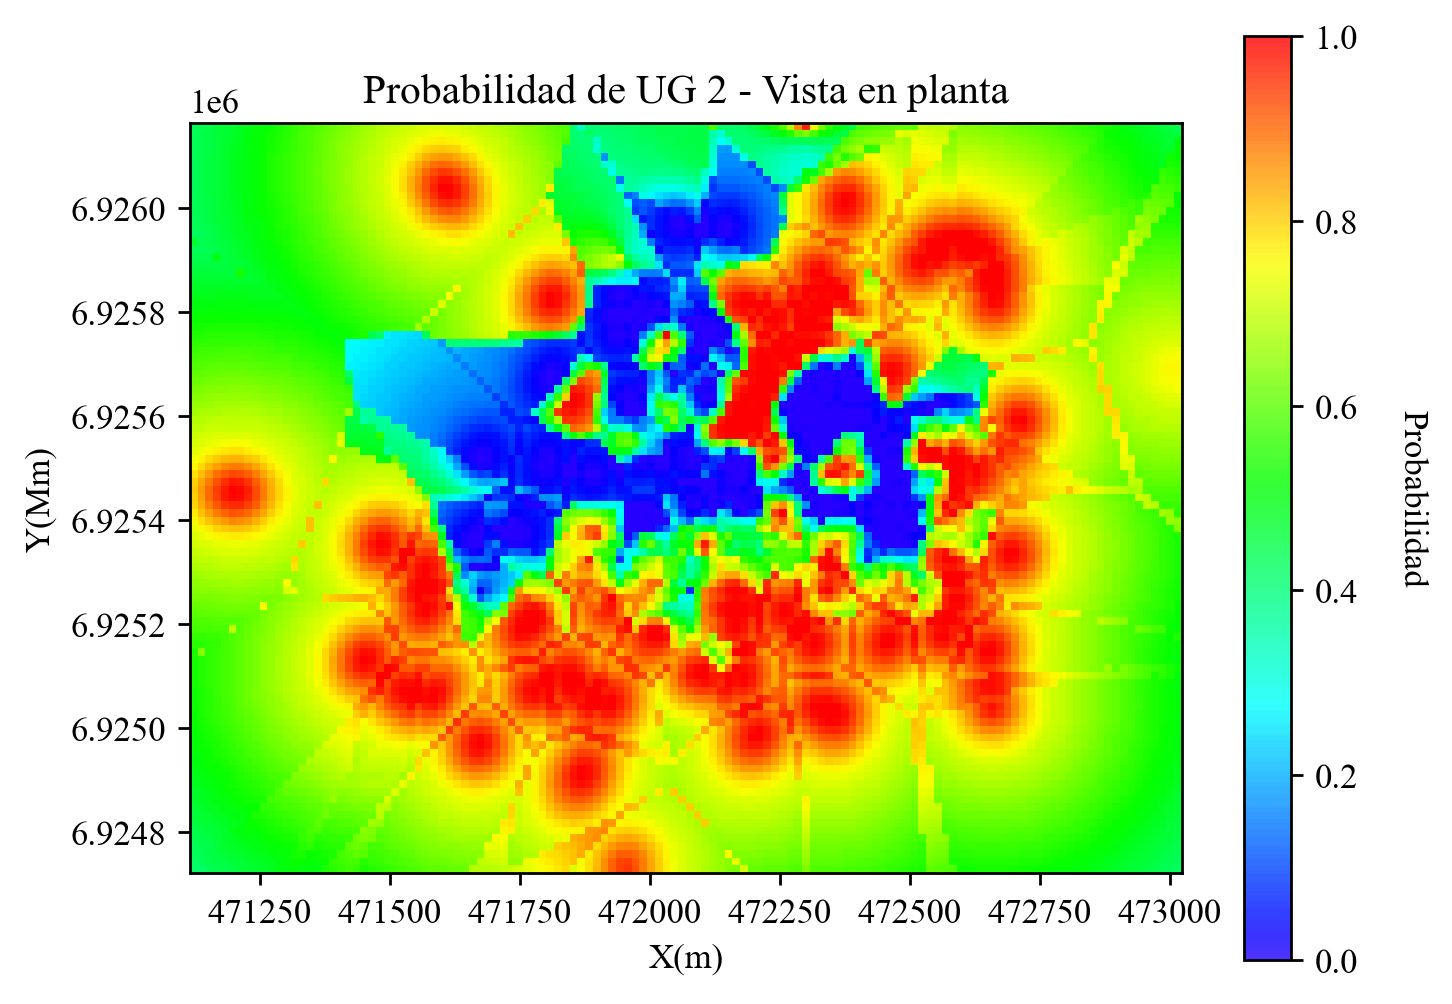

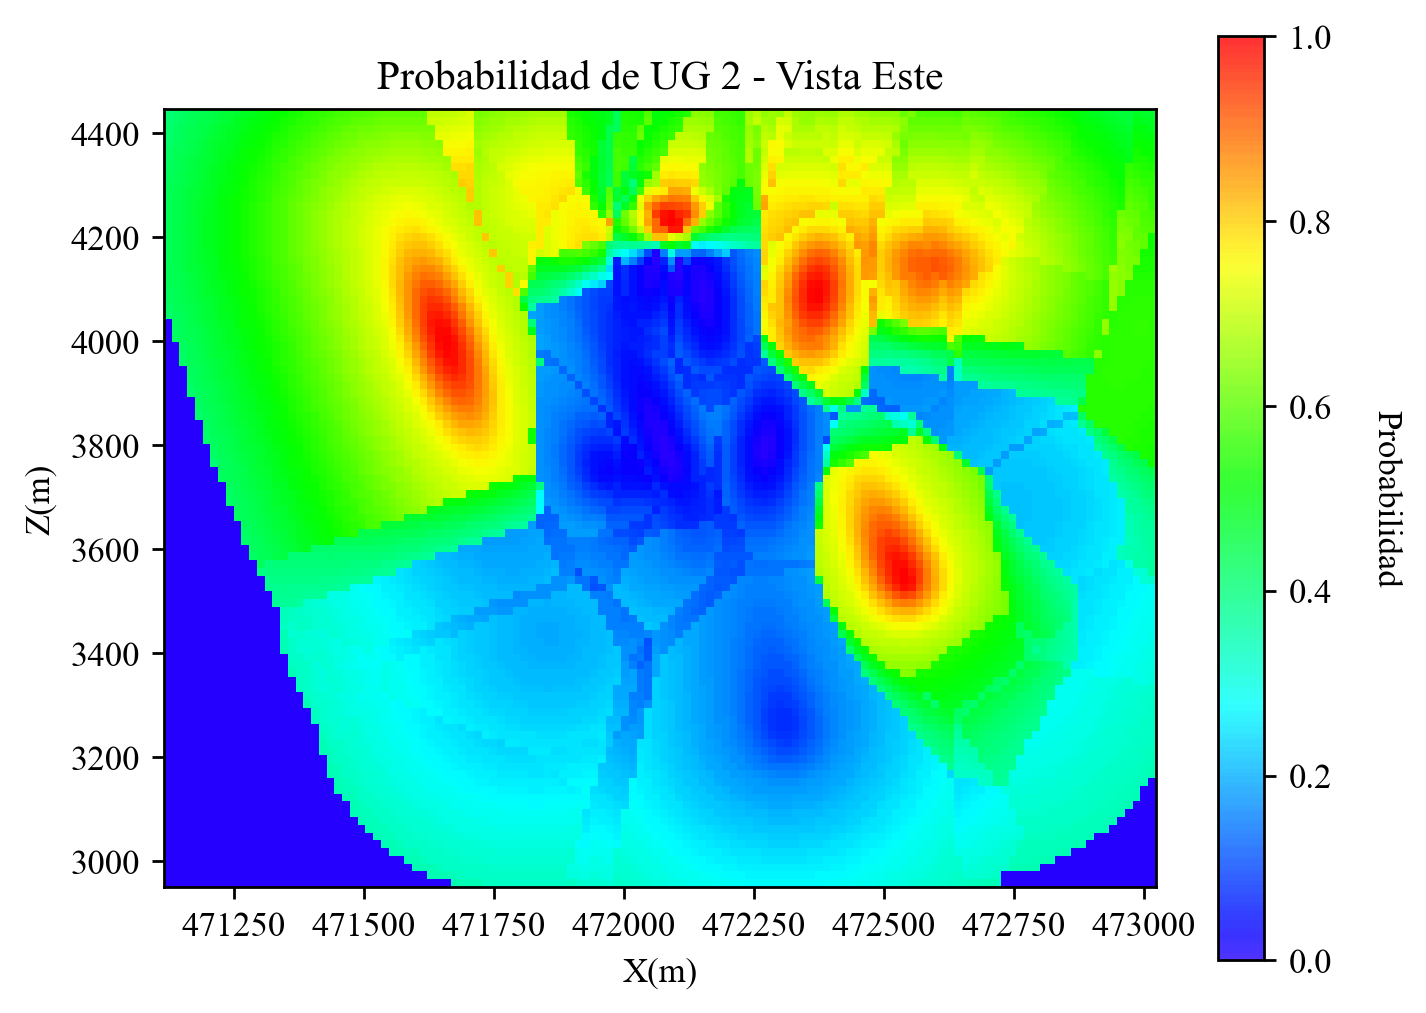

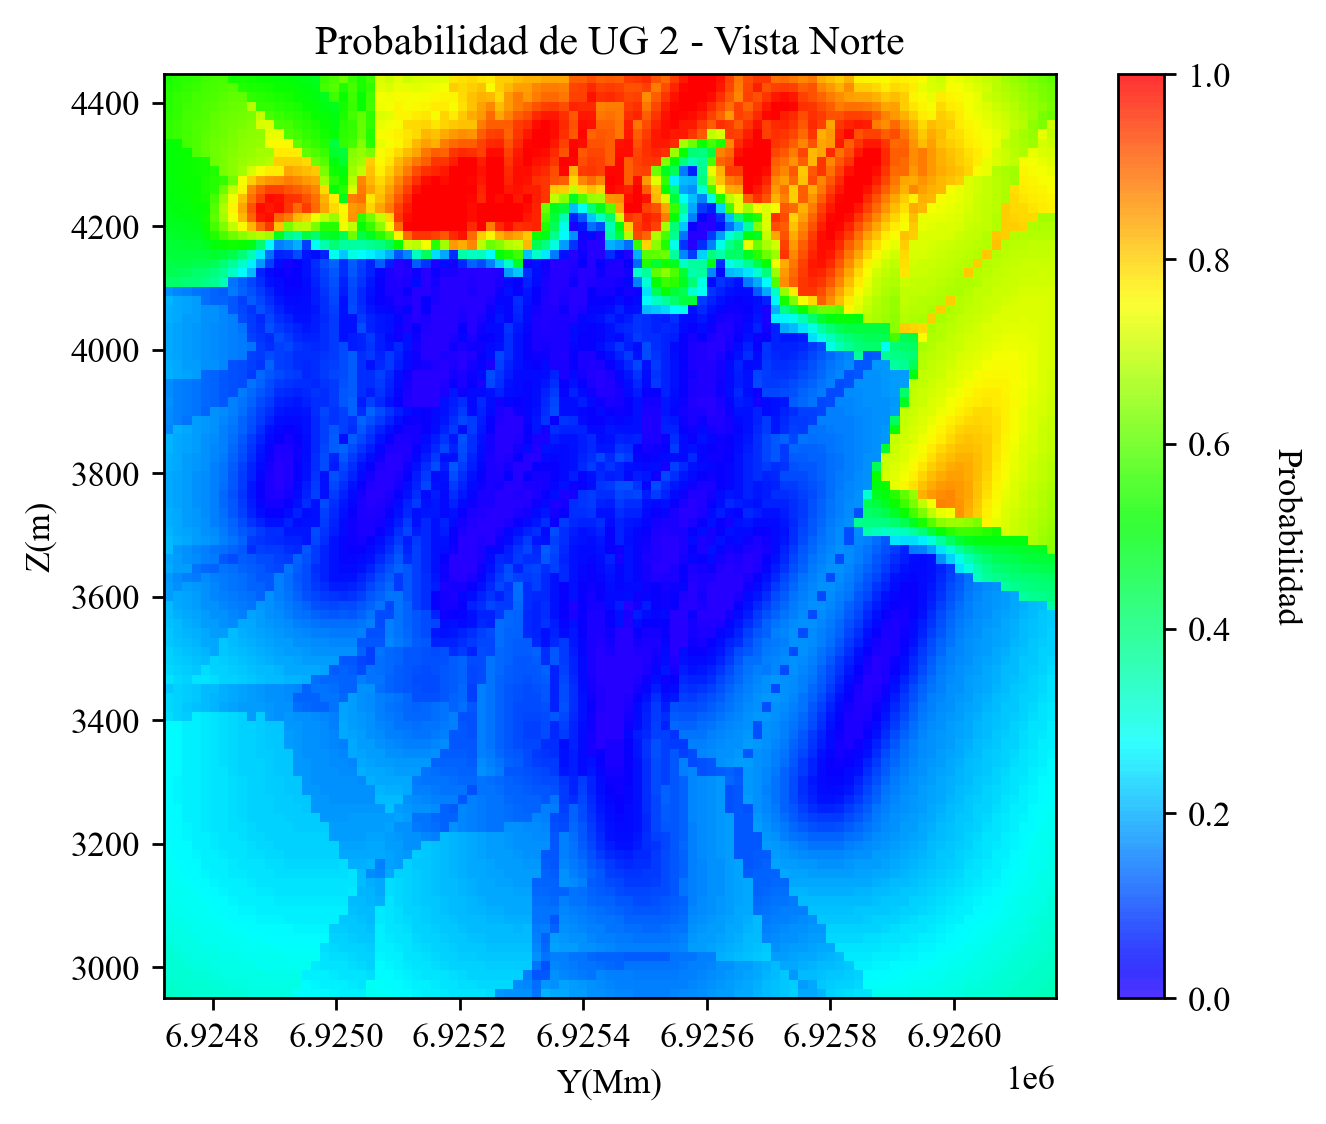

In [275]:
idz = 20; idy = 12; idx = 64   # índices para cortes en z, y, x respectivamente. Valores van entre 0 y nz-1, ny-1, nx-1

plt.subplots()
plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
GSLIB.pixelplt_st(ik_UG2[idz,:,:],xmin,xmax,ymin,ymax,15,0.0,1.0,'Probabilidad de UG 2 - Vista en planta','X(m)','Y(Mm)','Probabilidad',cmap)

plt.subplots()
plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
GSLIB.pixelplt_st(ik_UG2[:,idy,:],xmin,xmax,zmin,zmax,15,0.0,1.0,'Probabilidad de UG 2 - Vista Este','X(m)','Z(m)','Probabilidad',cmap)

plt.subplots()
plt.rcParams['figure.dpi'] = 250 # Setear resolución de la figura
GSLIB.pixelplt_st(ik_UG2[:,:,idx],ymin,ymax,zmin,zmax,15,0.0,1.0,'Probabilidad de UG 2 - Vista Norte','Y(Mm)','Z(m)','Probabilidad',cmap)



### Segunda UG

In [225]:
print(f"UG3 - Media: {mean_UG3:.2f}, Varianza: {var_UG3:.2f}")

UG3 - Media: 0.12, Varianza: 0.11


In [ ]:
parfile = '''                  Parameters for KT3D
                  *******************

START OF PARAMETERS:
./01_data/data_indicadores.dat              -file with data
0  1  2  3  7  0                 -   columns for DH,X,Y,Z,var,sec var
-1.0e21   1.0e21                 -   trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
0                                -debugging level: 0,1,2,3
kt3d.dbg                         -file for debugging output
./03_resultados/ikt3d_UG3.out                         -file for kriged output
128   471116.24    15			-nx,xmn,xsiz - AR: pegamos los valores de la grilla definida en la sección anterior
97   6924721.57    15			-ny,ymn,ysiz
100   2950.02    15			    -nz,zmn,zsiz
1    1      1                    -x,y and z block discretization
1    15                           -min, max data for kriging
0                                -max per octant (0-> not used)
50.0  50.0  50.0                -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
0     0.12                      -0=SK,1=OK,2=non-st SK,3=exdrift - AR: SK y proporcion de UG. NO OLVIDAR CAMBIAR
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.dat                     -gridded file with drift/mean
4                                -  column number in gridded file
1 0.0                            -nst, nugget effect - AR: variograma UG 3
1 0.10 0 0  0.0                 -it,cc,ang1,ang2,ang3                       
         100 100 100            -a_hmax, a_hmin, a_vert    
'''

with open("02_parametros/ikt3d_UG3.par", "w") as f:
    f.write(parfile)

In [ ]:
# Ejecutar kt3d de GSLIB
result = subprocess.run(["./Gslib90/kt3d", "./02_parametros/ikt3d_UG3.par"], capture_output=True, text=True, check=True)

In [ ]:
ik_UG3 = GSLIB.GSLIB2ndarray_3D("./03_resultados/ikt3d_UG3.out ", 0, 1, nx, ny, nz)[0][0]

### Tercera UG

In [ ]:
parfile = '''                  Parameters for KT3D
                  *******************

START OF PARAMETERS:
./01_data/data_indicadores.dat              -file with data
0  1  2  3  8  0                 -   columns for DH,X,Y,Z,var,sec var
-1.0e21   1.0e21                 -   trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -   columns for X,Y,Z,vr and sec var
0                                -debugging level: 0,1,2,3
kt3d.dbg                         -file for debugging output
./03_resultados/ikt3d_UG4.out                         -file for kriged output
128   471116.24    15			-nx,xmn,xsiz - AR: pegamos los valores de la grilla definida en la sección anterior
97   6924721.57    15			-ny,ymn,ysiz
100   2950.02    15			    -nz,zmn,zsiz
1    1      1                    -x,y and z block discretization
1    15                           -min, max data for kriging
0                                -max per octant (0-> not used)
50.0  50.0  50.0                -maximum search radii
 0.0   0.0   0.0                 -angles for search ellipsoid
0     0.51                      -0=SK,1=OK,2=non-st SK,3=exdrift
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.dat                     -gridded file with drift/mean
4                                -  column number in gridded file
1    0.0                        -Three  nst, nugget effect - AR: variograma UG 4
2    0.25 0 0  0.0              -it,cc,ang1,ang2,ang3                       
         650 650 650            -a_hmax, a_hmin, a_vert    
'''

with open("02_parametros/ikt3d_UG4.par", "w") as f:
    f.write(parfile)

In [ ]:
# Ejecutar vmodel de GSLIB
result = subprocess.run(["./Gslib90/kt3d", "./02_parametros/ikt3d_UG4.par"], capture_output=True, text=True, check=True)

In [ ]:
ik_UG4 = GSLIB.GSLIB2ndarray_3D("./03_resultados/ikt3d_UG4.out ", 0, 1, nx, ny, nz)[0][0]

### Visualizando nuestro modelo geológico

In [ ]:
# Cargar resultados de kriging de indicadores en caso de que no se quieran correr los cálculos anteriores

ik_UG2 = GSLIB.GSLIB2ndarray_3D("./03_resultados/ikt3d_UG2.out ", 0, 1, nx, ny, nz)[0][0]
ik_UG3 = GSLIB.GSLIB2ndarray_3D("./03_resultados/ikt3d_UG3.out ", 0, 1, nx, ny, nz)[0][0]
ik_UG4 = GSLIB.GSLIB2ndarray_3D("./03_resultados/ikt3d_UG4.out ", 0, 1, nx, ny, nz)[0][0]

Para generar un modelo geológico con kriging de indicadores, se debe proceder a seleccionar en cada bloque aquella categoría con el valor de probabilidad de ocurrencia mayor entre los modelos obtenidos. 

In [160]:
# Seleccionar la UG con mayor probabilidad para cada celda
modelo_ug = np.zeros((nz,ny,nx))
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            modelo_ug[k,j,i] = np.argmax([ik_UG2[k,j,i], ik_UG3[k,j,i], ik_UG4[k,j,i]]) + 2  # +2 para mapear a UG 2, 3, 4. CAMIBIAR SI SE USAN OTRAS UGs

In [248]:
# pio.renderers.default = "colab"
pio.renderers.default = "notebook" # usar esta linea en jupyter notebook o vscode

df["UG"] = df["UG"].astype(str)

fig = px.scatter_3d(df, x='X', y='Y', z='Z', color='UG',category_orders={'UG': sorted(df.groupby('UG').groups.keys())})
## se puede agregar el borde del marcador para mejor visibilidad
fig.update_traces(marker=dict(line=dict(width=0.5, color='Black')))
fig.update_layout(scene=dict(hovermode=False),font_family="Times New Roman",)
fig.update_traces(marker=dict(size=2.0))

# Mejor estilo para leyenda
fig.update_layout(
    title_text='Unidades y modelo geológico para Cu',
    legend_title_text='UGs',
    legend=dict(
        itemsizing='constant',
        font=dict(size=14),
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1
    )
)

icz = 80  # índice de corte en z (puede ajustarse), va entre 0 y nz-1

# Agregar cortes del modelo de UGs con la misma escala de colores de plotly
x_slice = np.flip(np.flipud(modelo_ug[:, :, icx]), axis=1)
y_slice = np.flip(modelo_ug[:, icy, :], axis=0)
z_slice = np.flip(modelo_ug[nz-icz, :, :], axis=0)

# Construir mapeo de colores usado por el scatter (categorías)
color_map = {}
for tr in fig.data:
    try:
        name = str(tr.name)
        color = tr.marker.color
        # marker.color puede ser lista (no esperado aquí) o string; tomamos el primer elemento si es lista
        if isinstance(color, (list, tuple, np.ndarray)):
            color = color[0]
        color_map[name] = color
    except Exception:
        continue

# Fallback a la paleta por defecto si no se obtuvo el mapeo
cats = [str(c) for c in sorted(df['UG'].unique())]
default_colors = px.colors.qualitative.Plotly
colors = [color_map.get(cat, default_colors[i % len(default_colors)]) for i, cat in enumerate(cats)]

# Construir colorscale discreto usando 3 paradas (normalizado entre cmin=2 y cmax=4)
colorscale = [(0.0, colors[0]), (0.5, colors[1]), (1.0, colors[2])]

# X-slice (plano constante x)
YY, ZZ = np.meshgrid(y_coords, z_coords)             # shapes (nz, ny)
XX = np.full_like(YY, x_coords[icx])
surf_x = go.Surface(
    x=XX, y=YY, z=ZZ,
    surfacecolor=x_slice.astype(float),
    cmin=2, cmax=4,     # Recuerda ajustar estos valores según las UGs usadas ej. si van entre 1 y 3 tus UGs
    colorscale=colorscale,
    showscale=False,
    opacity=1,
    name=f'corte X={x_coords[icx]:.1f}',
    hoverinfo='skip',
    hovertemplate=None
)

# Y-slice (plano constante y)
XX, ZZ = np.meshgrid(x_coords, z_coords)             # shapes (nz, nx)
YY = np.full_like(XX, y_coords[icy])
surf_y = go.Surface(
    x=XX, y=YY, z=ZZ,
    surfacecolor=y_slice.astype(float),
    cmin=2, cmax=4,
    colorscale=colorscale,
    showscale=False,
    opacity=1,
    name=f'corte Y={y_coords[icy]:.1f}',
    hoverinfo='skip',
    hovertemplate=None,
)

# Z-slice (plano constante z)
XX, YY = np.meshgrid(x_coords, y_coords)             # shapes (ny, nx)
ZZ = np.full_like(XX, z_coords[icz])
surf_z = go.Surface(
    x=XX, y=YY, z=ZZ,
    surfacecolor=z_slice.astype(float),
    cmin=2, cmax=4,
    colorscale=colorscale,
    showscale=False,
    opacity=1,
    name=f'corte Z={z_coords[icz]:.1f}',
    hoverinfo='skip',
    hovertemplate=None
)

# Añadir superficies al figure (manteniendo la leyenda y colores consistentes)
fig.add_trace(surf_x)
fig.add_trace(surf_y)
fig.add_trace(surf_z)

fig.show()

### Exportar modelo

Una vez verificado que las muestras iniciales coinciden hacen sentido con el modelo de unidades geologicas, podemos exportar este modelo de bloques, el cual **sera utilizado nuevamente una vez finalizada la estimacion de leyes dentro de cada unidad** para compilar el modelo de leyes finales.

In [232]:
## Exportar modelo de UGs en formato GSLIB
GSLIB.ndarray2GSLIB_3D(modelo_ug.astype(int),'./03_resultados/modelo_ug.dat', 'UG')